In [1]:
# Standard data libraries
import pandas as pd
import re
import string
import spacy

# For stopword removal & stemming (from NLTK)
from nltk.corpus import stopwords  # (5) Stop word removal
from nltk.stem import PorterStemmer  # (7) Stemming

# For visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# For vectorization and machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


# Load and Prepare Dataset

We import libraries for text processing (`re`, `string`, `spaCy`, `nltk`), visualization (`matplotlib`, `WordCloud`), and machine learning (`scikit-learn`, `xgboost`).


We load a CSV file containing YouTube comments and clean it by removing any missing values. Sentiment labels are encoded from text (positive/neutral/negative) to numerical values (2/1/0).

In [2]:
# Load cleaned YouTube comments dataset
df = pd.read_csv("YoutubeCommentsDataSet.csv")
df.dropna(subset=['Comment'], inplace=True)

# Convert string labels to numerical labels
df['Sentiment'] = df['Sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})


C:\Users\Asus\AppData\Local\Temp\ipykernel_5732\2900461298.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sentiment'] = df['Sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})


# Text Preprocessing

This step includes:
- (3) Case folding: converting all characters to lowercase  
- (4) Punctuation removal: using regex  
- (5) Stop word removal: using NLTK’s English stopword list  
- (6) Abbreviation handling: replacing common contractions  
- (7) Stemming: reducing words to their base form using PorterStemmer  
- (2) Tokenization: we use Python's `split()` as a basic tokenization method

In [3]:
# Load stopwords and stemmer
stop_words = set(stopwords.words('english'))  # (5)
stemmer = PorterStemmer()  # (7)

# (6) Abbreviation handling
abbrev_map = {"don't": "do not", "can't": "cannot", "i'm": "i am"}
def expand_abbreviations(text):
    for abbr, full in abbrev_map.items():
        text = text.replace(abbr, full)
    return text

# Preprocessing function
def preprocess(text):
    text = text.lower()  # (3) Case folding
    text = expand_abbreviations(text)  # (6)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # (4) Remove punctuation
    tokens = text.split()  # (2) Tokenization using .split()
    tokens = [t for t in tokens if t not in stop_words]  # (5)
    tokens = [stemmer.stem(t) for t in tokens]  # (7)
    return ' '.join(tokens)

# Apply preprocessing
df['Processed'] = df['Comment'].apply(preprocess)


# POS Tagging and Named Entity Recognition

- (1) Perform sentence segmentation *(internally via spaCy)*  
- (2) Perform tokenization with spaCy  
- (8) Extract Part-of-Speech (POS) tags for each word  
- Extract Named Entities (e.g., locations, organizations) — Bonus Task

In [4]:
# Load spaCy English model (includes sentence segmentation)
nlp = spacy.load("en_core_web_sm")

# Extract (1) Sentence segmentation, (2) Tokenization, (8) POS tagging, and Named Entities
def spacy_features(text):
    doc = nlp(text)  # (1) Sentence segmentation & (2) Tokenization happen here
    pos_tags = [(token.text, token.pos_) for token in doc]  # (8)
    ner = [(ent.text, ent.label_) for ent in doc.ents]
    return pd.Series([pos_tags, ner])

# Apply spaCy features
df[['POS_Tags', 'Named_Entities']] = df['Comment'].apply(spacy_features)


# Generate Word Cloud (for visual insight)

(bonus) Word Cloud Generation

We generate a Word Cloud based on all processed comments to visualize the most frequent words.

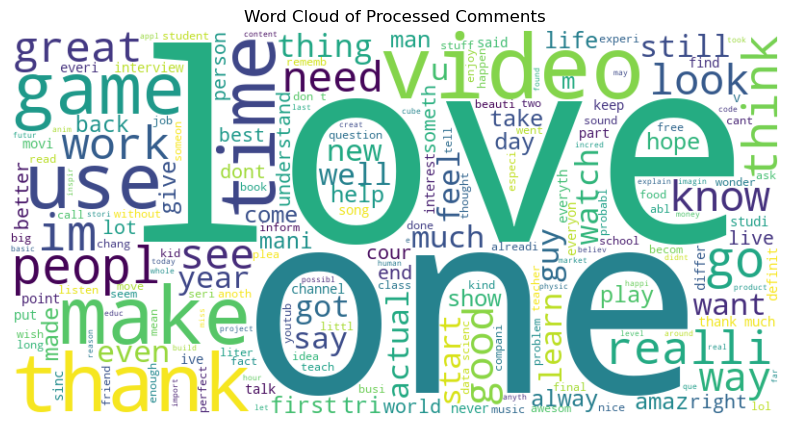

In [5]:
# Combine all processed text into one string
text_combined = ' '.join(df['Processed'].tolist())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Comments")
plt.show()


## Word Cloud Visualization of Frequent Words

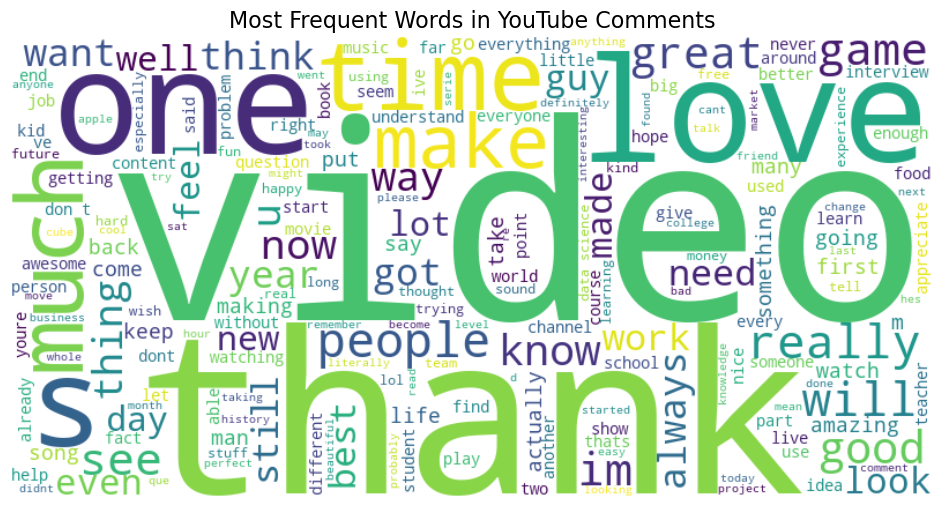

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all comments into one large string
text = " ".join(str(comment) for comment in df['Comment'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in YouTube Comments", fontsize=16)
plt.show()


# TF-IDF Vectorization and Train-Test Split

We convert our text into numeric features using the TF-IDF technique and split the dataset into training and testing sets for evaluation.

In [7]:
# Features and labels
X = df['Processed']
y = df['Sentiment']

# Split data for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
# Sentiment Analysis with TextBlob, VADER, and AFINN
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
afinn_analyzer = Afinn()

# Define sentiment functions
def analyze_textblob(text):
    return TextBlob(text).sentiment.polarity  # Range: [-1.0, 1.0]

def analyze_vader(text):
    return vader_analyzer.polarity_scores(text)['compound']  # Range: [-1.0, 1.0]

def analyze_afinn(text):
    return afinn_analyzer.score(text)  # Positive/Negative integers

# Apply sentiment analysis to original comments (not preprocessed ones)
df['TextBlob_Polarity'] = df['Comment'].apply(analyze_textblob)
df['VADER_Compound'] = df['Comment'].apply(analyze_vader)
df['AFINN_Score'] = df['Comment'].apply(analyze_afinn)

# View updated dataframe
df[['Comment', 'Sentiment', 'TextBlob_Polarity', 'VADER_Compound', 'AFINN_Score']].head()


,Comment,Sentiment,TextBlob_Polarity,VADER_Compound,AFINN_Score
0,lets not forget that apple pay in 2014 require...,1,0.075606,0.6774,0.0
1,here in nz 50 of retailers don’t even have con...,0,0.160000,0.8360,5.0
2,i will forever acknowledge this channel with t...,2,0.000000,0.8718,8.0
3,whenever i go to a place that doesn’t take app...,0,-0.195238,-0.8914,-9.0
4,apple pay is so convenient secure and easy to ...,2,0.208333,0.6786,1.0


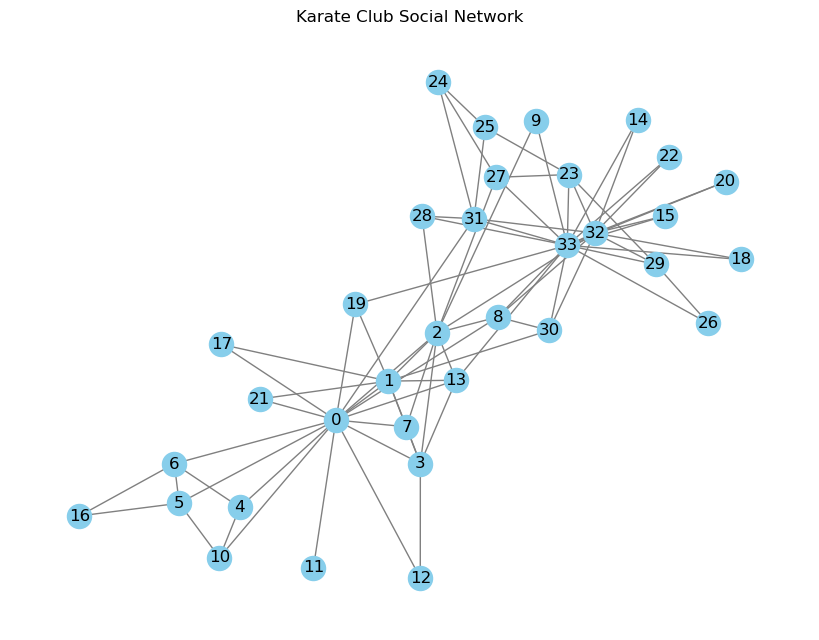

In [9]:
import networkx as nx

# Create a simple graph
G = nx.karate_club_graph()  # Common sample graph for SNA

# Draw the graph (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Karate Club Social Network")
plt.show()


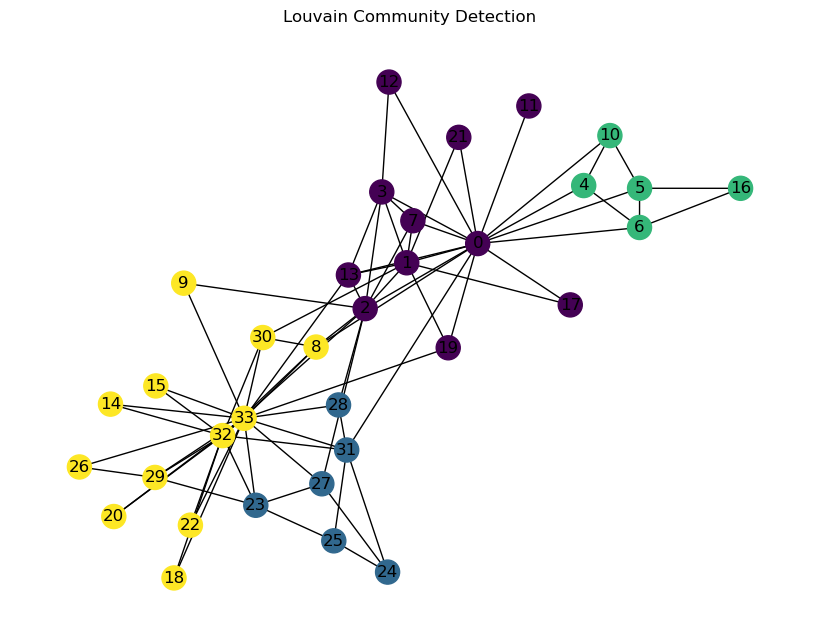

In [10]:
import community as community_louvain

# Compute best partition
partition = community_louvain.best_partition(G)

# Visualize community
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)
cmap = plt.get_cmap("viridis")
nx.draw(G, pos, node_color=[partition[n] for n in G.nodes()], with_labels=True, cmap=cmap)
plt.title("Louvain Community Detection")
plt.show()


In [11]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

# Centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Top influential nodes
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes by degree centrality:")
for node, score in sorted_degree[:5]:
    print(f"Node {node}: {score:.4f}")


Number of nodes: 34
Number of edges: 78
Average degree: 4.588235294117647
Top 5 nodes by degree centrality:
Node 33: 0.5152
Node 0: 0.4848
Node 32: 0.3636
Node 2: 0.3030
Node 1: 0.2727


In [12]:
# Save partition results to CSV
import pandas as pd
df_community = pd.DataFrame(list(partition.items()), columns=["Node", "Community"])
df_community.to_csv("louvain_communities.csv", index=False)


In [13]:
df_community.head()

,Node,Community
0,0,0
1,1,0
2,2,0
3,3,0
4,4,2


In [14]:
df_community.tail()

,Node,Community
29,29,3
30,30,3
31,31,1
32,32,3
33,33,3


# Sentiment Distribution (Bar and Pie Charts)

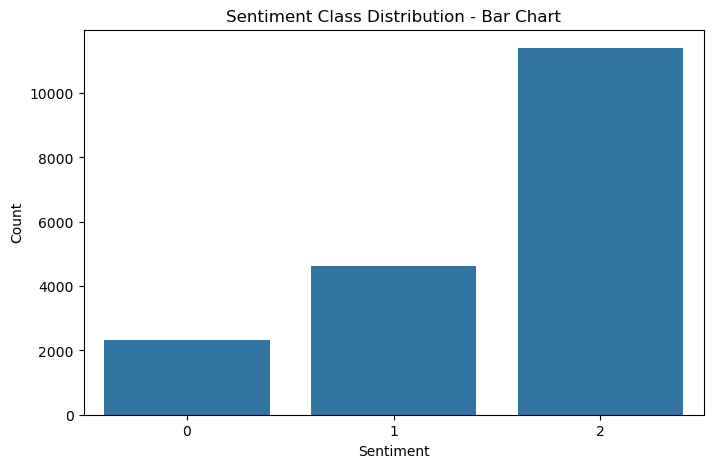

In [15]:
import seaborn as sns
import pandas as pd

# Count sentiment occurrences
sentiment_counts = df['Sentiment'].value_counts()

# Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Class Distribution - Bar Chart')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

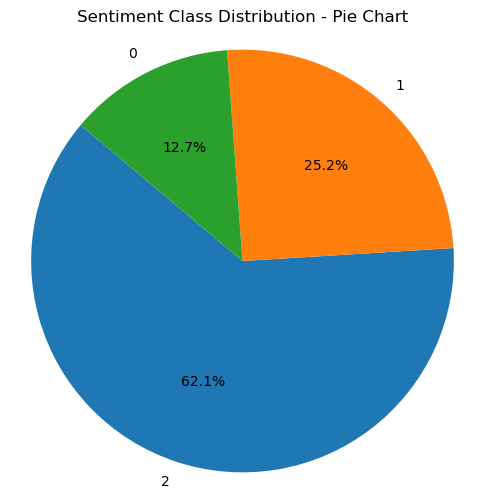

In [16]:
# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Class Distribution - Pie Chart')
plt.axis('equal')
plt.show()


# Train and Evaluate Multiple ML Models

We train five different machine learning models:
- Logistic Regression  
- Support Vector Machine (SVM)  
- Random Forest  
- Naive Bayes  
- XGBoost  

We evaluate them using accuracy and classification reports.

🔍 Training & Evaluation: Logistic Regression
✅ Accuracy: 0.7533
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.34      0.45       441
           1       0.61      0.58      0.60       912
           2       0.81      0.90      0.85      2320

    accuracy                           0.75      3673
   macro avg       0.69      0.61      0.63      3673
weighted avg       0.74      0.75      0.74      3673



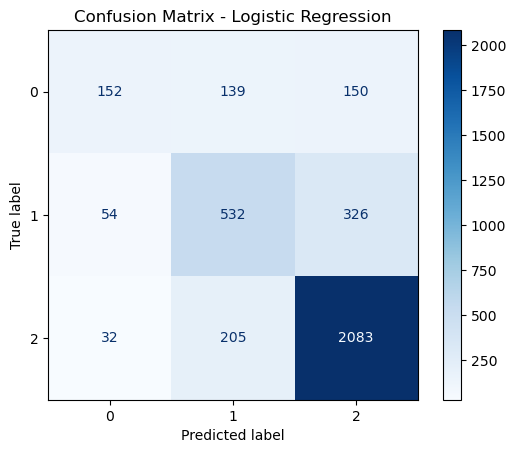

🔍 Training & Evaluation: SVM
✅ Accuracy: 0.7536
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.46       441
           1       0.59      0.61      0.60       912
           2       0.84      0.88      0.86      2320

    accuracy                           0.75      3673
   macro avg       0.67      0.62      0.64      3673
weighted avg       0.74      0.75      0.75      3673



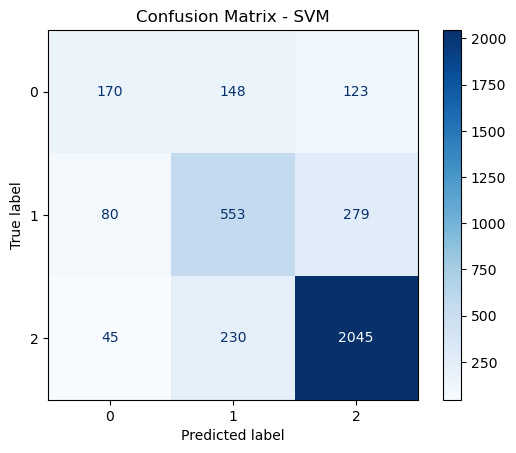

🔍 Training & Evaluation: Random Forest
✅ Accuracy: 0.7433
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.18      0.28       441
           1       0.65      0.56      0.60       912
           2       0.77      0.92      0.84      2320

    accuracy                           0.74      3673
   macro avg       0.70      0.55      0.57      3673
weighted avg       0.73      0.74      0.71      3673



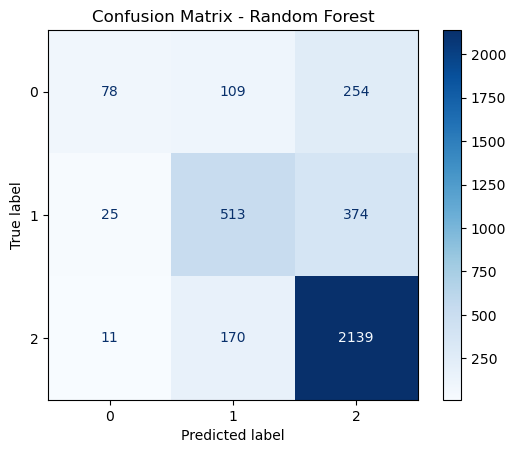

🔍 Training & Evaluation: Naive Bayes
✅ Accuracy: 0.6943
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.14      0.23       441
           1       0.72      0.28      0.40       912
           2       0.69      0.96      0.81      2320

    accuracy                           0.69      3673
   macro avg       0.70      0.46      0.48      3673
weighted avg       0.70      0.69      0.64      3673



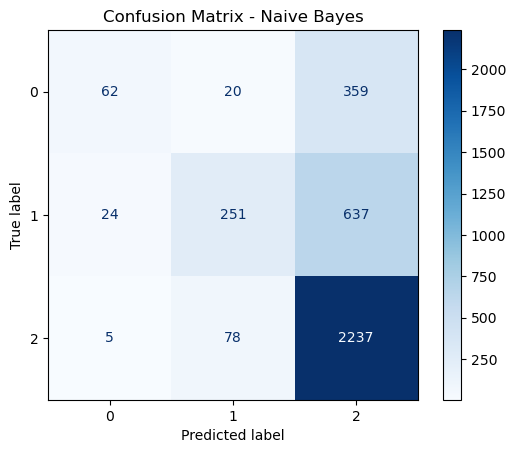

🔍 Training & Evaluation: XGBoost


C:\Users\Asus\anaconda3\envs\CDS6334\lib\site-packages\xgboost\training.py:183: UserWarning: [10:35:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.7517
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.28      0.39       441
           1       0.59      0.66      0.63       912
           2       0.83      0.88      0.85      2320

    accuracy                           0.75      3673
   macro avg       0.68      0.61      0.62      3673
weighted avg       0.74      0.75      0.74      3673



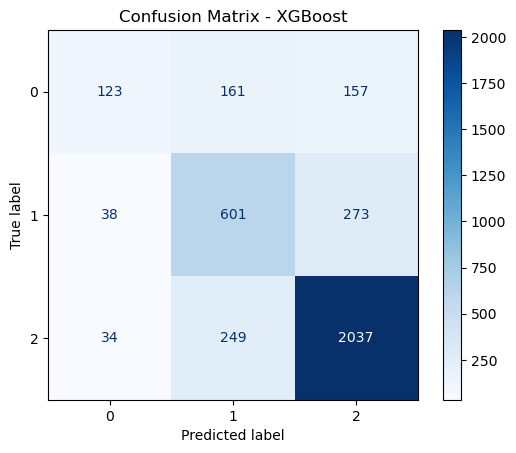

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import numpy as np

# Step 1: Prepare labels
classes = list(np.unique(y_train))
is_binary = len(classes) == 2

# Label encode y_test for ROC plotting if binary
if is_binary:
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)  # Required for roc_curve

# Step 2: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
}

# Step 3: Train and evaluate each model
for name, model in models.items():
    print("="*60)
    print(f"🔍 Training & Evaluation: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Classification metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve (only for binary)
    if is_binary:
        try:
            y_score = model.predict_proba(X_test_tfidf)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_encoded, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
            plt.title(f"ROC Curve - {name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"⚠️ ROC Curve Error for {name}: {e}")


# Logistic Regression Hyperparameter Tuning

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, verbose=2, n_jobs=-1)

# Fit on training data
grid_lr.fit(X_train_tfidf, y_train)

# Results
print("Best Parameters (Logistic Regression):", grid_lr.best_params_)
print("Best CV Score:", grid_lr.best_score_)

# Evaluate on test data
y_pred_lr = grid_lr.predict(X_test_tfidf)
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (Logistic Regression): {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Score: 0.7520931970257038
Tuned Logistic Regression Accuracy: 0.7533351483800708
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.34      0.45       441
           1       0.61      0.58      0.60       912
           2       0.81      0.90      0.85      2320

    accuracy                           0.75      3673
   macro avg       0.69      0.61      0.63      3673
weighted avg       0.74      0.75      0.74      3673



# Support Vector Machine (SVM) Hyperparameter Tuning

In [19]:
from sklearn.svm import SVC

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, verbose=2, n_jobs=-1)

# Fit on training data
grid_svm.fit(X_train_tfidf, y_train)

# Results
print("Best Parameters (SVM):", grid_svm.best_params_)
print("Best CV Score:", grid_svm.best_score_)

# Evaluate on test data
y_pred_svm = grid_svm.predict(X_test_tfidf)
print("Tuned SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.7504595946950369
Tuned SVM Accuracy: 0.7511570922951266
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.41      0.49       441
           1       0.60      0.57      0.58       912
           2       0.82      0.89      0.85      2320

    accuracy                           0.75      3673
   macro avg       0.68      0.62      0.64      3673
weighted avg       0.74      0.75      0.74      3673



# Random Forest Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, verbose=2, n_jobs=-1)

# Fit on training data
grid_rf.fit(X_train_tfidf, y_train)

# Results
print("Best Parameters (Random Forest):", grid_rf.best_params_)
print("Best CV Score:", grid_rf.best_score_)

# Evaluate on test data
y_pred_rf = grid_rf.predict(X_test_tfidf)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 162 candidates, totalling 810 fits


# Multinomial Naive Bayes Hyperparameter Tuning

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define parameter grid
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
}

# Initialize GridSearchCV
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, verbose=2, n_jobs=-1)

# Fit on training data
grid_nb.fit(X_train_tfidf, y_train)

# Results
print("Best Parameters (Naive Bayes):", grid_nb.best_params_)
print("Best CV Score:", grid_nb.best_score_)

# Evaluate on test data
y_pred_nb = grid_nb.predict(X_test_tfidf)
print("Tuned Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


# XGBoost (Extreme Gradient Boosting) Hyperparameter Tuning

In [ ]:
from xgboost import XGBClassifier

# Define parameter grid
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 500],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), param_grid_xgb, cv=5, verbose=2, n_jobs=-1)

# Fit on training data
grid_xgb.fit(X_train_tfidf, y_train)

# Results
print("Best Parameters (XGBoost):", grid_xgb.best_params_)
print("Best CV Score:", grid_xgb.best_score_)

# Evaluate on test data
y_pred_xgb = grid_xgb.predict(X_test_tfidf)
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


# ROC Curve (Multiclass)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Binarize for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = model.predict_proba(X_test_tfidf)  # update with appropriate model

# Plot ROC for each class
for i in range(y_score.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# Lexicon-Based Sentiment Analysis: TextBlob, VADER, AFINN

In [ ]:
texts = [
    "I love this product!",
    "This is the worst experience I've ever had.",
    "It's okay, nothing special.",
    "Absolutely fantastic! Highly recommended.",
    "Not bad, could be better.",
    "I hate this so much!",
    "The update ruined everything."
]

# TextBlob
print("\n📘 TextBlob Sentiment Analysis:")
for text in texts:
    blob = TextBlob(text)
    print(f"Text: {text}")
    print(f"  Polarity: {blob.sentiment.polarity}, Subjectivity: {blob.sentiment.subjectivity}")

# VADER
print("\n🟢 VADER Sentiment Analysis:")
vader_analyzer = SentimentIntensityAnalyzer()
for text in texts:
    score = vader_analyzer.polarity_scores(text)
    print(f"Text: {text}")
    print(f"  Compound: {score['compound']}, Pos: {score['pos']}, Neu: {score['neu']}, Neg: {score['neg']}")

# AFINN
print("\n🔵 AFINN Sentiment Analysis:")
af = Afinn()
for text in texts:
    score = af.score(text)
    print(f"Text: {text}")
    print(f"  AFINN Score: {score}")


# Aspect-Based Sentiment Analysis (ABSA)

To understand user sentiment towards specific features or topics (aspects) within each comment, we implemented a rule-based ABSA method using spaCy and TextBlob. This approach extracts noun phrases as candidate aspects and evaluates sentiment polarity using the TextBlob lexicon. We then aggregate sentiment scores per aspect to visualize user opinion trends.

In [ ]:
!pip install spacy textblob
import spacy
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Load English NLP model
nlp = spacy.load("en_core_web_sm")


In [ ]:
# Function to extract noun chunks (aspects)
def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text.split()) < 4]

# Sample data for performance
df_sample = df.sample(500, random_state=42).copy()
df_sample['aspects'] = df_sample['Comment'].apply(extract_aspects)
df_sample.head()


In [ ]:
aspect_sentiments = []

for idx, row in df_sample.iterrows():
    comment = row['Comment']
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    for aspect in row['aspects']:
        aspect_sentiments.append({
            'aspect': aspect,
            'comment': comment,
            'polarity': polarity,
            'sentiment': 'Positive' if polarity > 0.1 else 'Negative' if polarity < -0.1 else 'Neutral'
        })

aspect_df = pd.DataFrame(aspect_sentiments)
aspect_df.head()


In [ ]:
# Show top 10 aspects
top_aspects = aspect_df['aspect'].value_counts().head(10).index
filtered = aspect_df[aspect_df['aspect'].isin(top_aspects)]

# Plot
plt.figure(figsize=(10, 6))
filtered.groupby(['aspect', 'sentiment']).size().unstack().fillna(0).plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Aspect-Based Sentiment Distribution (Top 10 Aspects)")
plt.ylabel("Frequency")
plt.xlabel("Aspect")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Transformer-Based Feature Extraction (DistilBERT)

In [ ]:
# Install transformers if not already installed
# !pip install transformers

from transformers import pipeline

# Load pre-trained DistilBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Example: Predict sentiment for first 10 comments in your dataset
for comment in df['Comment'][:10]:
    result = sentiment_pipeline(str(comment))
    print(f"Comment: {comment}\nPrediction: {result}\n")

# To apply on full dataset and store results:
df['DistilBERT_sentiment'] = df['Comment'].apply(lambda x: sentiment_pipeline(str(x))[0]['label'])

# View sample results
df[['Comment', 'DistilBERT_sentiment']].head()
